In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
!pip install split-folders

In [ ]:
! unzip archive.zip 

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Dataset/with_mask/1890.png  
  inflating: Dataset/with_mask/1891.png  
  inflating: Dataset/with_mask/1892.png  
  inflating: Dataset/with_mask/1893.png  
  inflating: Dataset/with_mask/1894.png  
  inflating: Dataset/with_mask/1895.png  
  inflating: Dataset/with_mask/1896.png  
  inflating: Dataset/with_mask/1897.png  
  inflating: Dataset/with_mask/1898.png  
  inflating: Dataset/with_mask/1899.png  
  inflating: Dataset/with_mask/19.png  
  inflating: Dataset/with_mask/190.png  
  inflating: Dataset/with_mask/1900.png  
  inflating: Dataset/with_mask/1901.png  
  inflating: Dataset/with_mask/1902.png  
  inflating: Dataset/with_mask/1903.png  
  inflating: Dataset/with_mask/1904.png  
  inflating: Dataset/with_mask/1905.png  
  inflating: Dataset/with_mask/1906.png  
  inflating: Dataset/with_mask/1907.png  
  inflating: Dataset/with_mask/1908.png  
  inflating: Dataset/with_mask/1909.png  
  inflating: Dataset/with_mask/191.png  
  inflating

In [ ]:
import splitfolders
splitfolders.ratio('Dataset', output="./", seed=1337, ratio=(.9, .1)) 


Copying files: 0 files [00:00, ? files/s]
Copying files: 263 files [00:00, 2629.16 files/s]
Copying files: 774 files [00:00, 4086.16 files/s]
Copying files: 1224 files [00:00, 4273.28 files/s]
Copying files: 1721 files [00:00, 4546.11 files/s]
Copying files: 2211 files [00:00, 4673.61 files/s]
Copying files: 2679 files [00:00, 4499.22 files/s]
Copying files: 3131 files [00:00, 3932.46 files/s]
Copying files: 3604 files [00:00, 4158.18 files/s]
Copying files: 4081 files [00:00, 4332.71 files/s]
Copying files: 4524 files [00:01, 4053.90 files/s]
Copying files: 4939 files [00:01, 3606.66 files/s]
Copying files: 5415 files [00:01, 3904.95 files/s]
Copying files: 5820 files [00:01, 3932.34 files/s]
Copying files: 6224 files [00:01, 3620.77 files/s]
Copying files: 6683 files [00:01, 3878.72 files/s]
Copying files: 7082 files [00:01, 3768.29 files/s]
Copying files: 7467 files [00:01, 3108.95 files/s]
Copying files: 7801 files [00:02, 3004.82 files/s]
Copying files: 8185 files [00:02, 3210.47

In [ ]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True, vertical_flip = True, zoom_range = 0.1,
    shear_range = 0.1, width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 90,
)
test_data_generator = keras.preprocessing.image.ImageDataGenerator()

In [ ]:
train_data = train_data_generator.flow_from_directory("./train", target_size = (128, 128), batch_size = 1, shuffle = True)
test_data = test_data_generator.flow_from_directory("./val", target_size = (128,128), batch_size = 1, shuffle = True)

Found 8082 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
labels =train_data.class_indices
labels

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [ ]:
def get_array_from_datagen(train_generator):
    x=[]
    y=[]
    train_generator.reset()
    for i in range(train_generator.__len__()):
        a,b=train_generator.next()
        x.append(a)
        y.append(b)
    x=np.array(x, dtype = np.float32)
    y=np.array(y, dtype = np.float32)
    print(x.shape)
    print(y.shape)
    return x,y

X_train, y_train = get_array_from_datagen(train_data)
X_test, y_test = get_array_from_datagen(test_data)

(8082, 1, 128, 128, 3)
(8082, 1, 3)
(900, 1, 128, 128, 3)
(900, 1, 3)


In [ ]:
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
y_train = y_train.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

In [ ]:
import gc
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl

input_shape = (128, 128, 3)
class_num = len(labels)

def cnn1():
    return Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(class_num, activation='softmax')
    ])

In [ ]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 0,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [ ]:
model = cnn1()
model.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
history = model.fit(X_train, y_train ,epochs=25, validation_data=(X_test, y_test),
                    verbose=2, callbacks = [learning_rate_reduction, early_stopping])
gc.collect()

Epoch 1/25
253/253 - 48s - loss: 2.4160 - accuracy: 0.7231 - val_loss: 0.6048 - val_accuracy: 0.7411
Epoch 2/25
253/253 - 17s - loss: 0.5410 - accuracy: 0.7847 - val_loss: 0.5852 - val_accuracy: 0.8011
Epoch 3/25
253/253 - 17s - loss: 0.5059 - accuracy: 0.7999 - val_loss: 0.4735 - val_accuracy: 0.8356
Epoch 4/25
253/253 - 17s - loss: 0.4950 - accuracy: 0.8096 - val_loss: 0.5406 - val_accuracy: 0.7967
Epoch 5/25
253/253 - 17s - loss: 0.4609 - accuracy: 0.8150 - val_loss: 0.5536 - val_accuracy: 0.8033
Epoch 6/25
253/253 - 17s - loss: 0.4591 - accuracy: 0.8182 - val_loss: 0.5147 - val_accuracy: 0.8333
Epoch 7/25
253/253 - 17s - loss: 0.3526 - accuracy: 0.8639 - val_loss: 0.3947 - val_accuracy: 0.8656
Epoch 8/25
253/253 - 17s - loss: 0.3151 - accuracy: 0.8712 - val_loss: 0.4978 - val_accuracy: 0.8389
Epoch 9/25
253/253 - 17s - loss: 0.2844 - accuracy: 0.8886 - val_loss: 0.4378 - val_accuracy: 0.8700
Epoch 10/25
253/253 - 17s - loss: 0.2824 - accuracy: 0.8857 - val_loss: 0.4490 - val_accura

1644

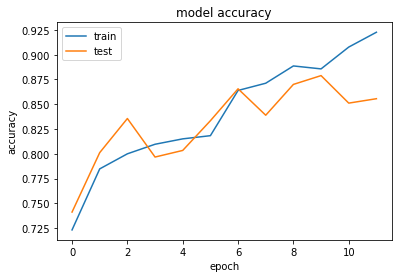

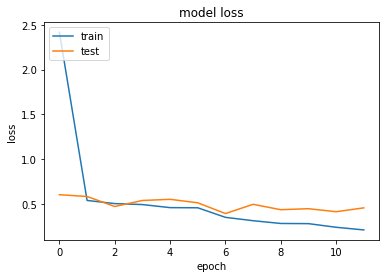

In [ ]:
plot_history(history)

In [ ]:
def cnn2():
    return Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(class_num, activation='softmax')
    ])

In [ ]:
model = cnn2()
model.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
history = model.fit(X_train, y_train ,epochs=25, validation_data=(X_test, y_test),
                    verbose=2, callbacks = [learning_rate_reduction, early_stopping])
gc.collect()

Epoch 1/25
253/253 - 16s - loss: 0.8537 - accuracy: 0.7575 - val_loss: 0.6309 - val_accuracy: 0.8144
Epoch 2/25
253/253 - 14s - loss: 0.5062 - accuracy: 0.8000 - val_loss: 0.7045 - val_accuracy: 0.6811
Epoch 3/25
253/253 - 14s - loss: 0.4755 - accuracy: 0.8103 - val_loss: 1.6329 - val_accuracy: 0.4533
Epoch 4/25
253/253 - 14s - loss: 0.4492 - accuracy: 0.8224 - val_loss: 0.5438 - val_accuracy: 0.8144
Epoch 5/25
253/253 - 14s - loss: 0.3570 - accuracy: 0.8615 - val_loss: 0.4473 - val_accuracy: 0.8400
Epoch 6/25
253/253 - 14s - loss: 0.3198 - accuracy: 0.8761 - val_loss: 0.4884 - val_accuracy: 0.8456
Epoch 7/25
253/253 - 14s - loss: 0.2676 - accuracy: 0.8937 - val_loss: 0.4184 - val_accuracy: 0.8733
Epoch 8/25
253/253 - 14s - loss: 0.2340 - accuracy: 0.9107 - val_loss: 0.6727 - val_accuracy: 0.7644
Epoch 9/25
253/253 - 14s - loss: 0.2061 - accuracy: 0.9206 - val_loss: 0.4346 - val_accuracy: 0.8300
Epoch 10/25
253/253 - 14s - loss: 0.1869 - accuracy: 0.9319 - val_loss: 0.3477 - val_accura

7299

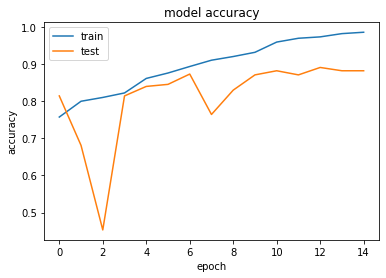

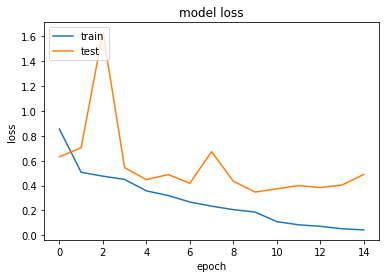

In [ ]:
plot_history(history)

In [ ]:
def cnn3():
    return Sequential([
        Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Dropout(0.3),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(class_num, activation='softmax')
    ])

In [ ]:
model = cnn3()
model.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
history = model.fit(X_train, y_train ,epochs=25, validation_data=(X_test, y_test),
                    verbose=2, callbacks = [learning_rate_reduction, early_stopping])
gc.collect()


Epoch 1/25
253/253 - 83s - loss: 1.5286 - accuracy: 0.7439 - val_loss: 0.9029 - val_accuracy: 0.7567
Epoch 2/25
253/253 - 74s - loss: 0.5077 - accuracy: 0.8005 - val_loss: 1.0020 - val_accuracy: 0.5278
Epoch 3/25
253/253 - 74s - loss: 0.4816 - accuracy: 0.8086 - val_loss: 0.7279 - val_accuracy: 0.7367
Epoch 4/25
253/253 - 74s - loss: 0.4446 - accuracy: 0.8232 - val_loss: 0.6140 - val_accuracy: 0.8044
Epoch 5/25
253/253 - 74s - loss: 0.3955 - accuracy: 0.8385 - val_loss: 0.8086 - val_accuracy: 0.6478
Epoch 6/25
253/253 - 74s - loss: 0.4052 - accuracy: 0.8411 - val_loss: 0.6765 - val_accuracy: 0.7800
Epoch 7/25
253/253 - 74s - loss: 0.3548 - accuracy: 0.8591 - val_loss: 0.5271 - val_accuracy: 0.8289
Epoch 8/25
253/253 - 74s - loss: 0.3287 - accuracy: 0.8722 - val_loss: 0.5980 - val_accuracy: 0.8067
Epoch 9/25
253/253 - 74s - loss: 0.2839 - accuracy: 0.8895 - val_loss: 0.5063 - val_accuracy: 0.8278
Epoch 10/25
253/253 - 74s - loss: 0.2738 - accuracy: 0.8994 - val_loss: 0.6891 - val_accura

7552

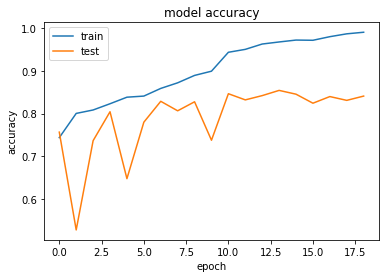

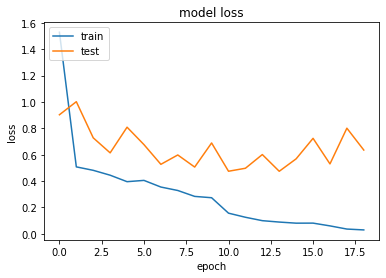

In [ ]:
plot_history(history)

Re run CNN1

In [ ]:
model = cnn1()
model.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
history = model.fit(X_train, y_train ,epochs=25, validation_data=(X_test, y_test),
                    verbose=2, callbacks = [learning_rate_reduction, early_stopping])
gc.collect()

Epoch 1/25
253/253 - 18s - loss: 1.9299 - accuracy: 0.7309 - val_loss: 0.5135 - val_accuracy: 0.8022
Epoch 2/25
253/253 - 17s - loss: 0.5171 - accuracy: 0.7940 - val_loss: 0.5530 - val_accuracy: 0.8000
Epoch 3/25
253/253 - 17s - loss: 0.4868 - accuracy: 0.8112 - val_loss: 0.6331 - val_accuracy: 0.7789
Epoch 4/25
253/253 - 17s - loss: 0.4569 - accuracy: 0.8189 - val_loss: 0.4536 - val_accuracy: 0.8078
Epoch 5/25
253/253 - 17s - loss: 0.4500 - accuracy: 0.8200 - val_loss: 0.4903 - val_accuracy: 0.8167
Epoch 6/25
253/253 - 17s - loss: 0.4233 - accuracy: 0.8301 - val_loss: 0.5811 - val_accuracy: 0.8144
Epoch 7/25
253/253 - 17s - loss: 0.4001 - accuracy: 0.8409 - val_loss: 0.4238 - val_accuracy: 0.8533
Epoch 8/25
253/253 - 17s - loss: 0.3769 - accuracy: 0.8508 - val_loss: 0.4526 - val_accuracy: 0.8289
Epoch 9/25
253/253 - 17s - loss: 0.3545 - accuracy: 0.8640 - val_loss: 0.3693 - val_accuracy: 0.8389
Epoch 10/25
253/253 - 17s - loss: 0.3364 - accuracy: 0.8677 - val_loss: 0.4099 - val_accura

9539

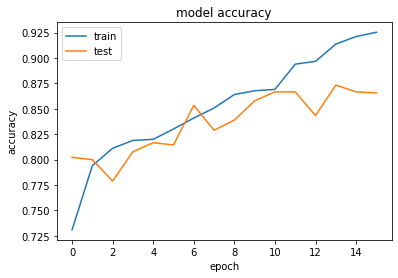

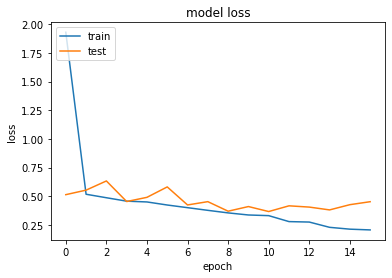

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       300
           1       0.88      0.81      0.84       300
           2       0.91      0.87      0.89       300

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



In [ ]:
import os
from shutil import copyfile
os.mkdir("./test_data")
os.mkdir("./test_data/with_mask")
os.mkdir("./test_data/mask_weared_incorrect")
os.mkdir("./test_data/without_mask")

In [ ]:
paths = []
names = []
k = 0
path = "./val/mask_weared_incorrect"
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("mask_weared_incorrect")
    copyfile(path + "/" + i, f"test_data/mask_weared_incorrect/{i}")
    k += 1
    if k == 8:
        break
k = 0
path = "./val/with_mask"
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("with_mask")
    copyfile(path + "/" + i, f"test_data/with_mask/{i}")
    k += 1
    if k == 8:
        break
path = "./val/without_mask"
k = 0
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("without_mask")
    copyfile(path + "/" + i,  f"test_data/without_mask/{i}")
    k += 1
    if k == 9:
        break

In [ ]:
test_data_2 = test_data_generator.flow_from_directory("./test_data", target_size = (128,128), batch_size = 1, shuffle = False)

Found 25 images belonging to 3 classes.


In [ ]:
print(labels)
labels_2 = {}
for k,v in labels.items():
    labels_2[v] = k
labels_2

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

In [ ]:
predictions = model.predict(test_data_2).argmax(axis = 1)
pred_label = []
for i in predictions:
    pred_label.append(labels_2[i])
pred_label

['mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'mask_weared_incorrect',
 'with_mask',
 'mask_weared_incorrect',
 'with_mask',
 'mask_weared_incorrect',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask']

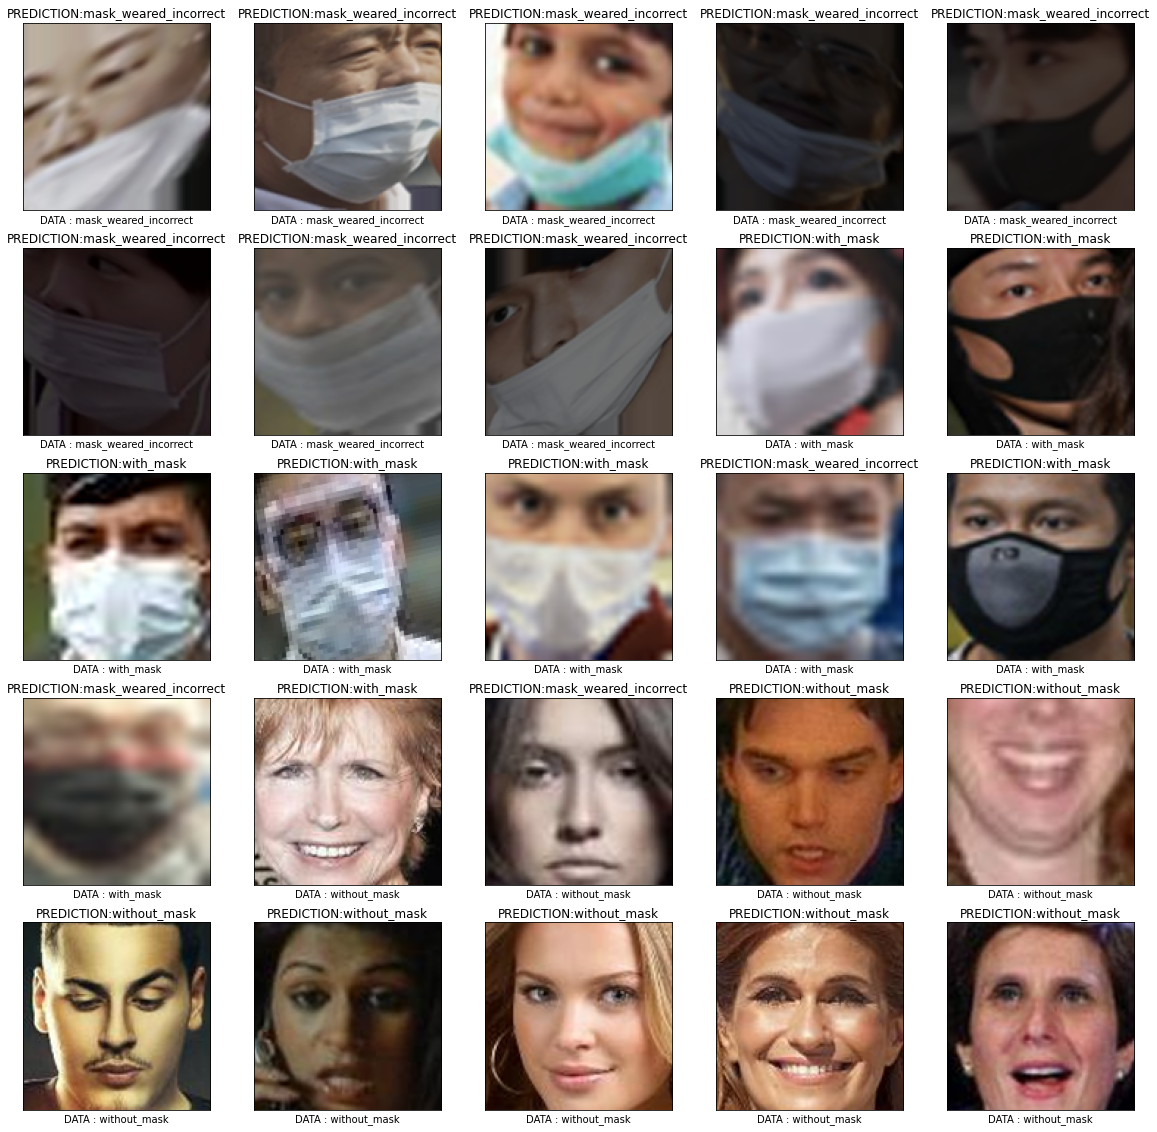

In [ ]:
import os
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(paths[i]))
    ax.set_title(f"PREDICTION:{pred_label[i]}")
    ax.set_xlabel(f"DATA : {names[i]}")
#plt.tight_layout()
plt.show()
